In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Dataset, TensorDataset
import os
import pytest
from google.colab import drive
import pandas as pd
import math
import datetime
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.init as init
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
sns.set()

In [ ]:
# auxiliary functions for data loading
def df_to_X_y(df):
  df_as_np = df.to_numpy()

  X = df_as_np[:-1, :] # daily values (open, high, low and close)
  Y = df_as_np[1:, :]

  return X.astype(np.float32), Y.astype(np.float32)

def str_to_datetime(s): # used to convert the date into an index
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

Mounted at /content/drive


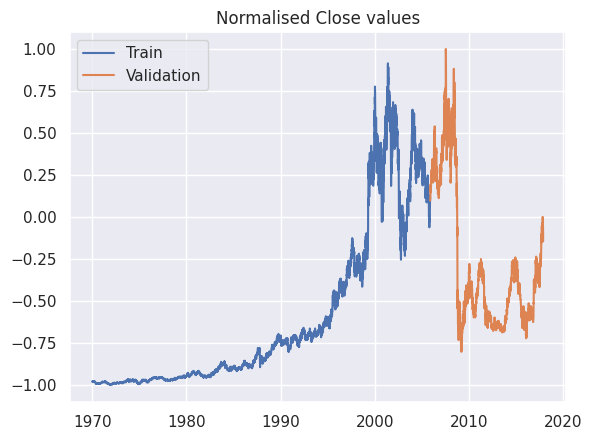

In [ ]:
drive.mount('/content/drive')
data_path = '/content/drive/Shared drives/Deep Learning/FinalProject/Data/' # modify path accordingly
df = pd.read_csv(data_path + "aa.us.csv") # use data following the same structure as this csv
results_path = '/content/drive/Shared drives/Deep Learning/FinalProject/Results/'

df['Date'] = df['Date'].apply(str_to_datetime)
df = df[['Date', 'Open', 'High', 'Low', 'Close']]
df.index = df.pop('Date')
scaler = MinMaxScaler(feature_range=(-1, 1))
df['Open'] = scaler.fit_transform(df['Open'].values.reshape(-1,1))
df['High'] = scaler.fit_transform(df['High'].values.reshape(-1,1))
df['Low'] = scaler.fit_transform(df['Low'].values.reshape(-1,1))
df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))

q_80 = int(len(df['Close']) * .75)

train = df.iloc[:q_80, :]
test = df.iloc[q_80:, :]

# the dataset below are already np arrays
X_train, y_train = df_to_X_y(train)
X_test, y_test = df_to_X_y(test)

plt.plot(train["Close"])
plt.plot(test["Close"])
plt.title("Normalised Close values")
plt.legend(['Train', 'Validation'])

In [ ]:
dataset_train = np.hstack((X_train, y_train))
dataset_test = np.hstack((X_test, y_test))
len_train = len(dataset_train)
len_test = len(dataset_test)
len_seq = 50

"""
structure of one element:

feature feature feature feature
feature feature feature feature
feature feature feature feature
target  target  target  target

using sliding windows
the columns are the open, high, low and close of the current day
by targeting at all the feature for the next day we can project data into the future
reuse outputs as inputs and capture trends for the future
"""

class MyDataset(Dataset):
    def __init__(self, data, window):
        self.data = data
        self.window = window

    def __getitem__(self, index):
        x = self.data[index:index + self.window, 0:4]  # keeping all features except the last column
        y = self.data[index+self.window, 4:]     # target all the features
        return x, y

    def __len__(self):
        return len(self.data) - self.window

dataset_train = MyDataset(dataset_train, len_seq)
dataset_test = MyDataset(dataset_test, len_seq)

data_loader_train = DataLoader(dataset_train, batch_size=len_seq)
data_loader_test = DataLoader(dataset_test, batch_size=1) # loading one sequence at a time

In [ ]:
class StockLN(nn.Module):
    def __init__(self, input_dims, hidden_size, num_layers):
        super(StockLN, self).__init__()

        self.lstm = nn.LSTM(input_size=input_dims, hidden_size=hidden_size, num_layers=num_layers, dropout=0.3, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 4) # for multilabel the output must be 4
        self.do = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[-1,-1,:]
        x = self.fc1(x)
        x = self.do(x)
        x = self.fc2(x)
        return x

In [ ]:
def train_test_model(model, criterion, optimizer, train_loader, test_loader, epochs, tolerance):

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    loss_list = []
    for epoch in range(epochs):
        model.train()
        total_step = len(train_loader)
        for i, (features, labels) in enumerate(train_loader):
            features = features.to(device)
            labels = labels.to(device)

            # forward pass
            outputs = model(features)
            loss = criterion(outputs, labels[-1])

            # backward and optimize
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            loss_list.append(loss.item())
            if ((i+1) % 100 == 0) or (i==total_step-1):
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch+1, epochs, i+1, total_step, loss.item()))

    # save the model checkpoint for transfer learning
    if not os.path.exists(results_path):
        os.makedirs(results_path)
    torch.save(model.state_dict(), os.path.join(results_path, 'model.ckpt'))

    # testing
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for features, labels in test_loader:
            features = features.to(device)
            labels = labels.to(device)

            # network predictions
            outputs = model(features)

            within_tolerance = torch.abs(outputs - labels[-1]) <= tolerance

            if all(within_tolerance == True):
                correct+=1

        total = len_test
        test_accuracy = 100 * correct / total
        print('Final test Accuracy of the model: {:.2f} %'.format(test_accuracy))

    return loss_list

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [1/250], Step [100/181], Loss: 0.0160
Epoch [1/250], Step [181/181], Loss: 0.0020
Epoch [2/250], Step [100/181], Loss: 0.0076
Epoch [2/250], Step [181/181], Loss: 0.0075
Epoch [3/250], Step [100/181], Loss: 0.0070
Epoch [3/250], Step [181/181], Loss: 0.0054
Epoch [4/250], Step [100/181], Loss: 0.0033
Epoch [4/250], Step [181/181], Loss: 0.0010
Epoch [5/250], Step [100/181], Loss: 0.0098
Epoch [5/250], Step [181/181], Loss: 0.0040
Epoch [6/250], Step [100/181], Loss: 0.0018
Epoch [6/250], Step [181/181], Loss: 0.0083
Epoch [7/250], Step [100/181], Loss: 0.0082
Epoch [7/250], Step [181/181], Loss: 0.0017
Epoch [8/250], Step [100/181], Loss: 0.0016
Epoch [8/250], Step [181/181], Loss: 0.0000
Epoch [9/250], Step [100/181], Loss: 0.0028
Epoch [9/250], Step [181/181], Loss: 0.0016
Epoch [10/250], Step [100/181], Loss: 0.0008
Epoch [10/250], Step [181/181], Loss: 0.0000
Epoch [11/250], Step [100/181], Loss: 0.0033
Epoch [11/250], Step [181/181], Loss: 0.0002
Epoch [12/250], Step [100/18

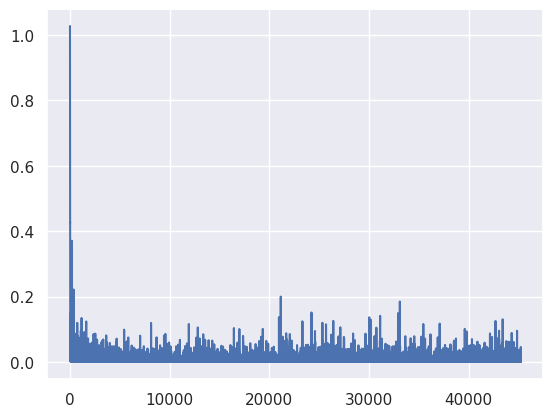

In [ ]:
model = StockLN(input_dims=4, hidden_size=61, num_layers=1) # this values proved empirically to be the best performing ones, an excel with different params can be found in the repo
criterion = nn.MSELoss(reduction="mean") # mean squared error loss for regression task
optimizer = optim.Adam(model.parameters(), lr=1e-3)

loss_list = train_test_model(model, criterion, optimizer, data_loader_train, data_loader_test,epochs=250, tolerance=0.1)
plt.plot(loss_list)

In [ ]:
def predict(model, num_days):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    current_data = df.iloc[int(len(df['Close']))-len_seq : , :].to_numpy().astype(np.float32)
    current_data = torch.tensor(current_data)
    current_data = current_data.unsqueeze(0).to(device)
    print(current_data.shape)

    predictions = []
    model.eval()
    with torch.no_grad():
        for _ in range(num_days):
            prediction = model(current_data)
            predictions.append(prediction.cpu().numpy())
            prediction = prediction.unsqueeze(0).unsqueeze(0)
            current_data = torch.cat((current_data[:, -len_seq+1:, :], prediction), dim=1).to(device)

    return predictions

torch.Size([1, 50, 4])
[array([-0.14360172, -0.15285146, -0.133537  , -0.13811433], dtype=float32), array([-0.1451608 , -0.15439472, -0.13511574, -0.13968283], dtype=float32), array([-0.14735126, -0.15655941, -0.13732654, -0.14188224], dtype=float32), array([-0.14985618, -0.15903443, -0.13985321, -0.14439648], dtype=float32), array([-0.15249777, -0.16164449, -0.14251748, -0.14704788], dtype=float32), array([-0.15520132, -0.16431594, -0.14524427, -0.14976156], dtype=float32), array([-0.15794158, -0.16702366, -0.14800811, -0.15251213], dtype=float32), array([-0.16071177, -0.169761  , -0.1508022 , -0.15529281], dtype=float32), array([-0.16351098, -0.17252707, -0.15362555, -0.15810257], dtype=float32), array([-0.1663396 , -0.17532218, -0.15647852, -0.16094193], dtype=float32), array([-0.16919816, -0.1781469 , -0.15936175, -0.16381133], dtype=float32), array([-0.17208713, -0.18100166, -0.16227567, -0.16671127], dtype=float32), array([-0.1750069 , -0.18388689, -0.16522068, -0.16964218], dtyp

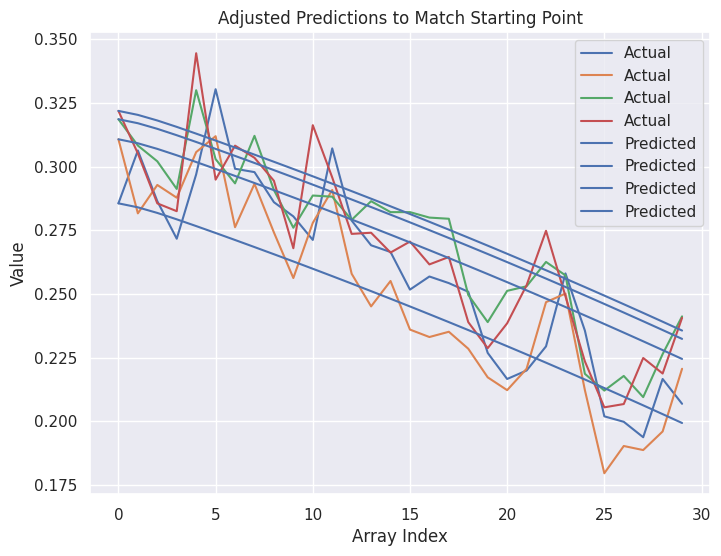

In [ ]:
# generate predictions
number_of_days = 30 # one month is quite a lot
# this part will only caption the trend and not the fluctuations

predictions = predict(model, number_of_days)
print('Predictions:', predictions)

# starting point is adjusted using the test data
list1 = []
i = 0
for features, labels in data_loader_test:
    if i < number_of_days:
        list1.append(labels[-1])
        i += 1

# extracting the last element from each array in predictions
last_elements = [arr[-1] for arr in predictions]

# adjust the starting point of predictions to match the first element of the list
starting_point = list1[0]
prediction_start = last_elements[0]
offset = starting_point - prediction_start
adjusted_predictions = [pred + offset for pred in last_elements]

plt.figure(figsize=(8, 6))
plt.plot(list1, label='Actual')
plt.plot(adjusted_predictions, color='b', label='Predicted')
plt.title('Adjusted Predictions to Match Starting Point')
plt.xlabel('Array Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def predict(model, train_loader, test_loader):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    model.eval()
    with torch.no_grad():
        total = 0
        predictions = []
        labels_plot = []

        for features, labels in test_loader:
            features = features.to(device)
            labels = labels.to(device)
            # network predictions
            outputs = model(features)

            predictions.append(outputs[-1].cpu().numpy())
            labels_plot.append(labels[-1][-1].cpu().numpy())

    plt.figure(figsize=(10, 5))
    plt.plot(predictions, label='Predictions', color='blue')
    plt.plot(labels_plot, label='Actual Labels', color='orange')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.title('Model Predictions vs Actual Labels (Cost)')
    plt.legend()
    plt.show()

    return predictions

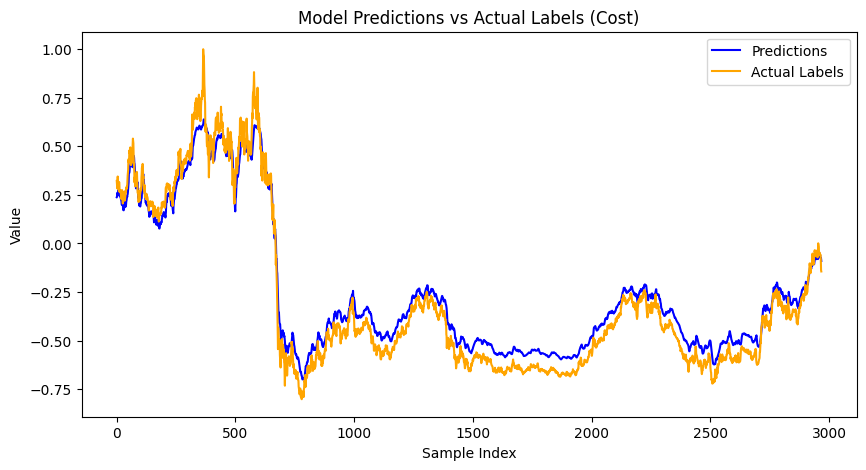

In [ ]:
predictions = predict(model, data_loader_train ,data_loader_test)